In [2]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
import keras.backend as K
from keras.models import load_model

In [4]:
from tensorflow.python.client import device_lib

print(tf.test.is_gpu_available())
print('-'*30)
print(tf.test.gpu_device_name())
print('-'*30)
print(tf.config.list_physical_devices('GPU'))
print('-'*30)
print(device_lib.list_local_devices())

True
------------------------------
/device:GPU:0
------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1094132276475974662
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10317004800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8414186570131329232
physical_device_desc: "device: 0, name: NVIDIA TITAN V, pci bus id: 0000:01:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [7]:
SEED = 909

BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = r'N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\PUBLIC_CT'
data_dir_train = os.path.join(data_dir, 'train')
data_dir_train_image = os.path.join(data_dir_train, 'image')
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test')
data_dir_test_image = os.path.join(data_dir_test, 'image')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

In [6]:
print(data_dir_train_image)
print(data_dir_train_mask)

print(data_dir_test_image)
print(data_dir_test_mask)

N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\PUBLIC_CT\train\image
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\PUBLIC_CT\train\mask
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\PUBLIC_CT\test\image
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\PUBLIC_CT\test\mask


In [6]:
def create_seg_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale = 1./255)
    img_datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = img_datagen.flow_from_directory(img_path, 
                                                    target_size = IMG_SIZE,
                                                    class_mode = None,
                                                    color_mode = 'grayscale',
                                                    batch_size = BATCH_SIZE, 
                                                    seed = SEED)
    msk_generator = img_datagen.flow_from_directory(msk_path, 
                                                    target_size = IMG_SIZE,
                                                    class_mode = None,
                                                    color_mode = 'grayscale',
                                                    batch_size = BATCH_SIZE, 
                                                    seed = SEED)
    return zip(img_generator, msk_generator)

In [8]:
train_generator = create_seg_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_seg_generator_train(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 3105 images belonging to 1 classes.
Found 3105 images belonging to 1 classes.
Found 545 images belonging to 1 classes.
Found 545 images belonging to 1 classes.


In [39]:
NUM_TRAIN = 3105
NUM_TEST = 545

NUM_EPOCHS = 13

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = 'gray')
    plt.show()

In [12]:
def show_dataset(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        display([image[0], mask[0]])

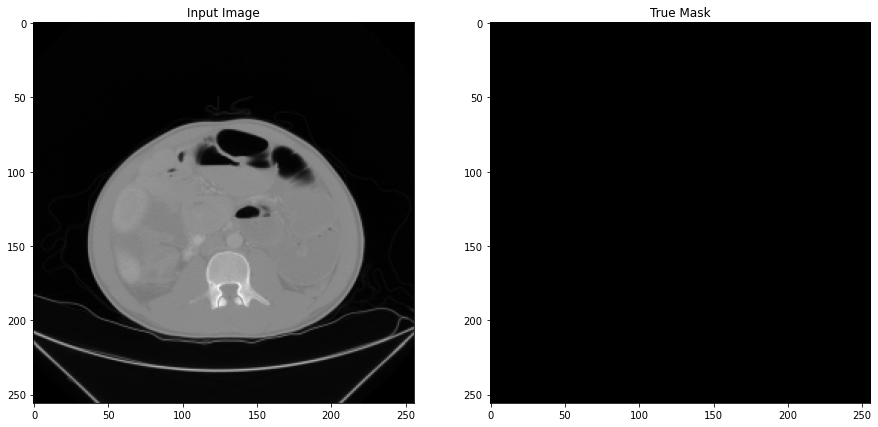

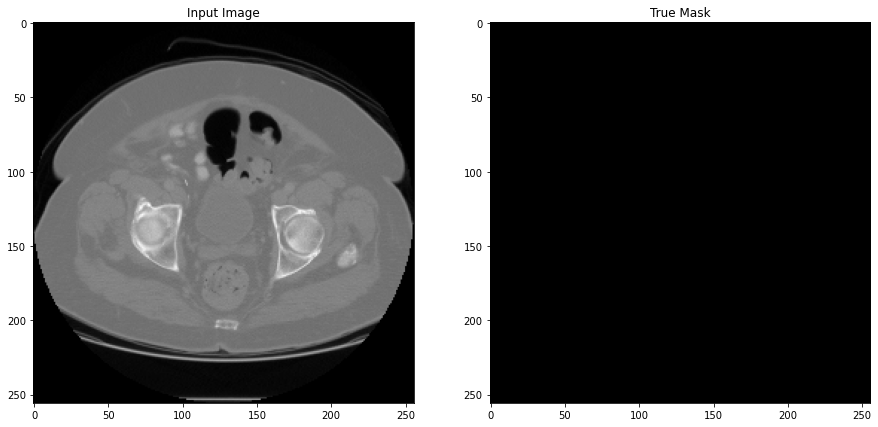

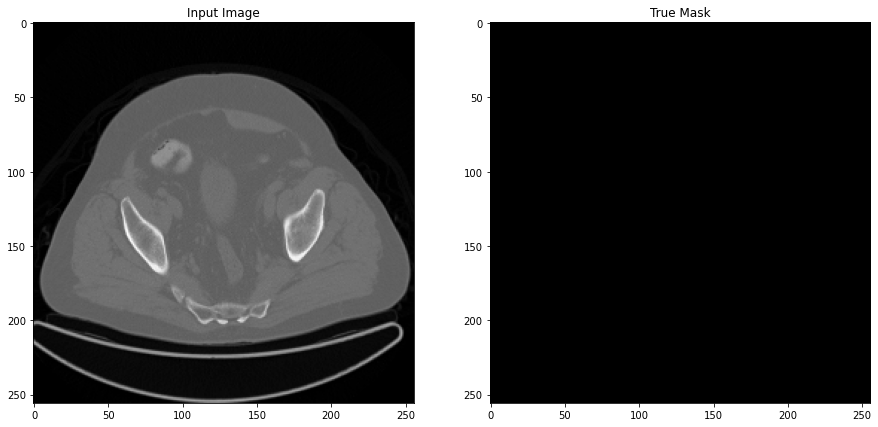

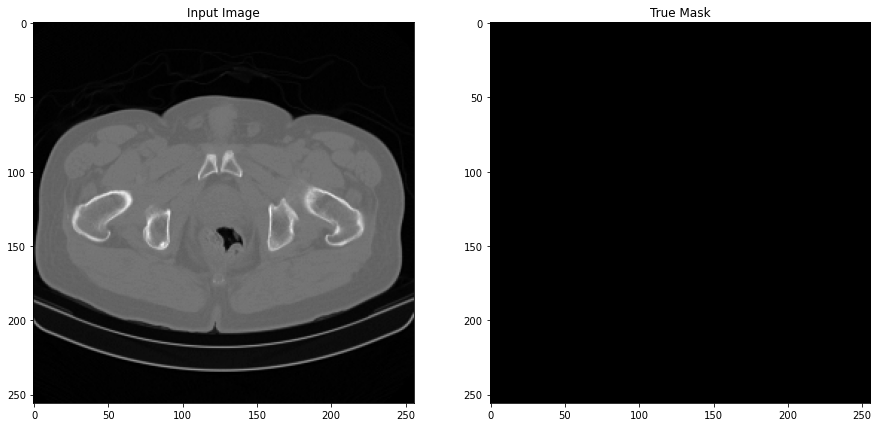

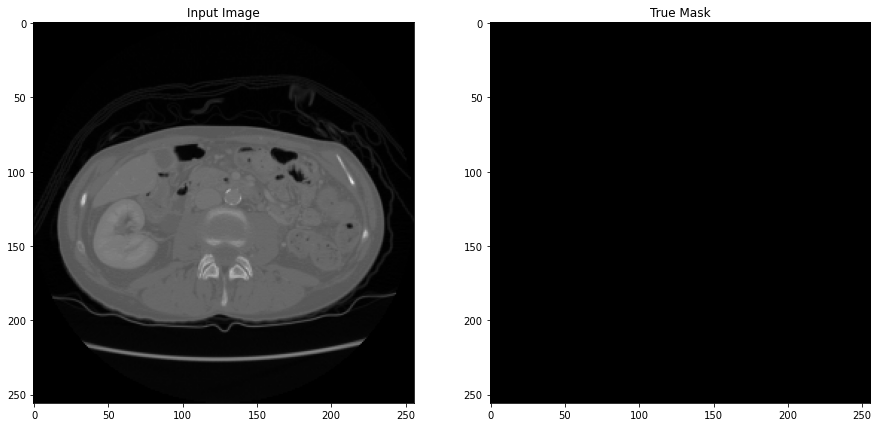

In [13]:
show_dataset(train_generator, 5)

In [14]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape = (IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size = kernel_size, activation = 'relu', padding = 'same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels -1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
    
    #upstream
    for level in reversed(range(n_levels - 1)):
            x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides = pooling_size, **convpars)(x)
            x = keras.layers.Concatenate()([x, skips[level]])
            for _ in range(n_blocks):
                x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
    
    #output
    x = keras.layers.Conv2D(out_channels, kernel_size = 1, activation = 'sigmoid', padding = 'same')(x)
    
    return keras.Model(inputs = [inputs], outputs = [x], 
                       name = f'2D_UNET_L{n_levels}_F{initial_features}_H{IMAGE_HEIGHT}_W{IMAGE_WIDTH}')

In [31]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [32]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(7)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef, dice_coef_loss])

In [37]:
checkpoint_filepath = 'weights_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True)

In [40]:
model.fit_generator(generator = train_generator, steps_per_epoch = EPOCH_STEP_TRAIN,
          validation_data = test_generator, validation_steps = EPOCH_STEP_TEST,
          epochs = NUM_EPOCHS, callbacks=[model_checkpoint_callback])

C:\Users\tdelg\AppData\Local\Temp/ipykernel_21512/3460705294.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = train_generator, steps_per_epoch = EPOCH_STEP_TRAIN,


Epoch 1/13
97/97 [==============================] - 105s 1s/step - loss: 0.0011 - accuracy: 0.9996 - dice_coef: 0.9211 - dice_coef_loss: 0.0789 - val_loss: 0.0069 - val_accuracy: 0.9978 - val_dice_coef: 0.7177 - val_dice_coef_loss: 0.2823
Epoch 2/13
97/97 [==============================] - 91s 940ms/step - loss: 8.1245e-04 - accuracy: 0.9997 - dice_coef: 0.9410 - dice_coef_loss: 0.0590 - val_loss: 0.0332 - val_accuracy: 0.9948 - val_dice_coef: 0.6776 - val_dice_coef_loss: 0.3224
Epoch 3/13
97/97 [==============================] - 91s 946ms/step - loss: 9.2916e-04 - accuracy: 0.9996 - dice_coef: 0.9343 - dice_coef_loss: 0.0657 - val_loss: 0.0134 - val_accuracy: 0.9975 - val_dice_coef: 0.7130 - val_dice_coef_loss: 0.2870
Epoch 4/13
97/97 [==============================] - 91s 945ms/step - loss: 0.0027 - accuracy: 0.9990 - dice_coef: 0.8119 - dice_coef_loss: 0.1881 - val_loss: 0.0112 - val_accuracy: 0.9971 - val_dice_coef: 0.6109 - val_dice_coef_loss: 0.3891
Epoch 5/13
97/97 [============

In [43]:
model.load_weights('weights_best.hdf5')
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef, dice_coef_loss])

In [44]:
model.save(f'2D_UNET_SPLEEN_CT_L7_H{IMAGE_HEIGHT}_W{IMAGE_WIDTH}.h5')

In [45]:
test_generator = create_seg_generator_train(data_dir_test_image, data_dir_test_mask, 1)

Found 545 images belonging to 1 classes.
Found 545 images belonging to 1 classes.


In [46]:
def show_prediction(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

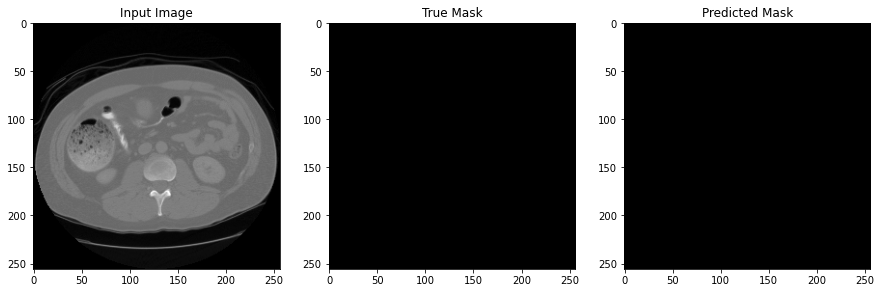

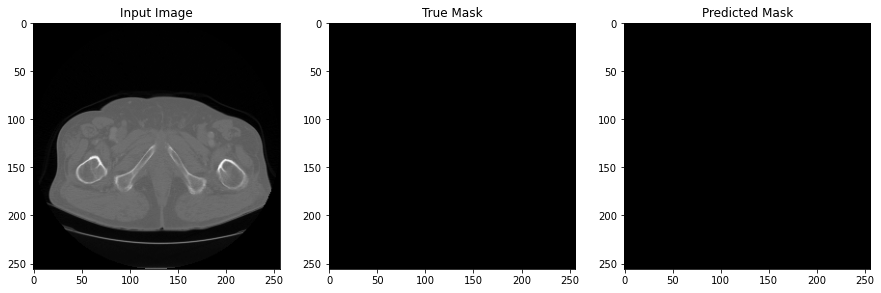

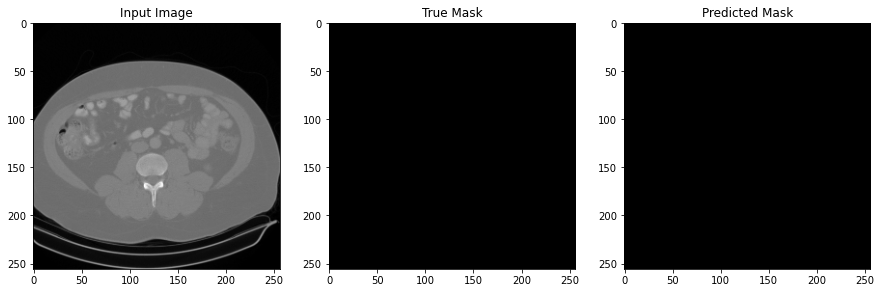

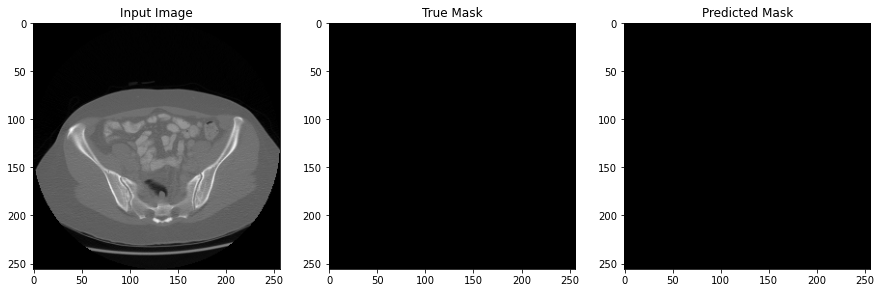

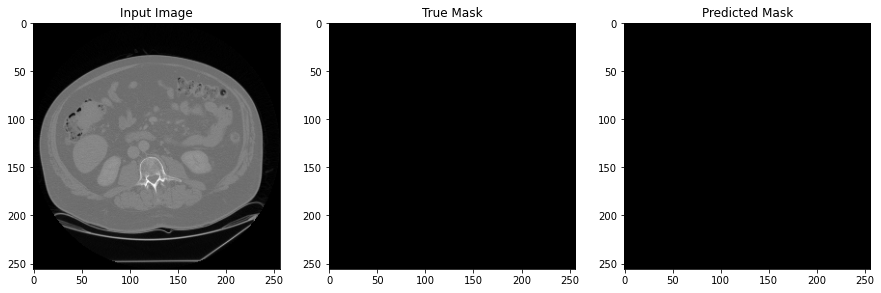

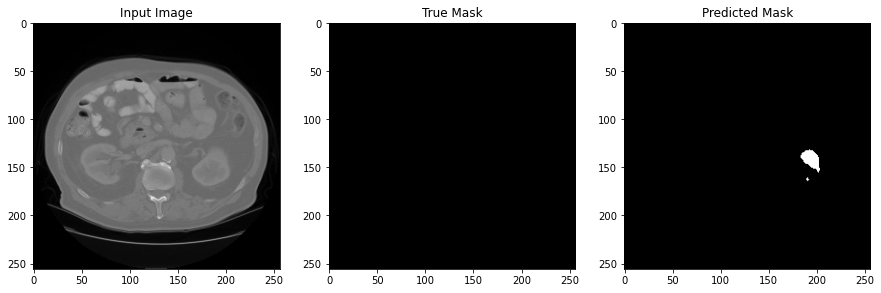

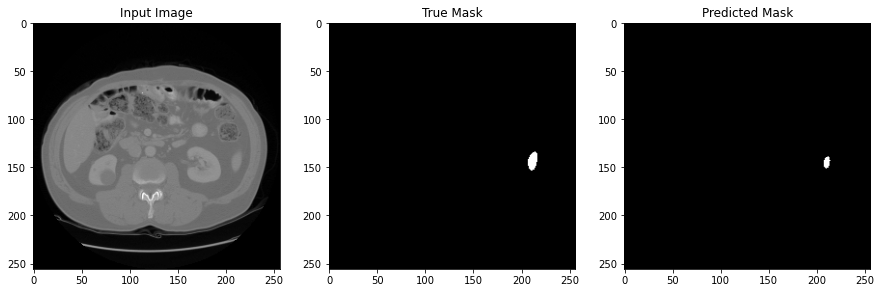

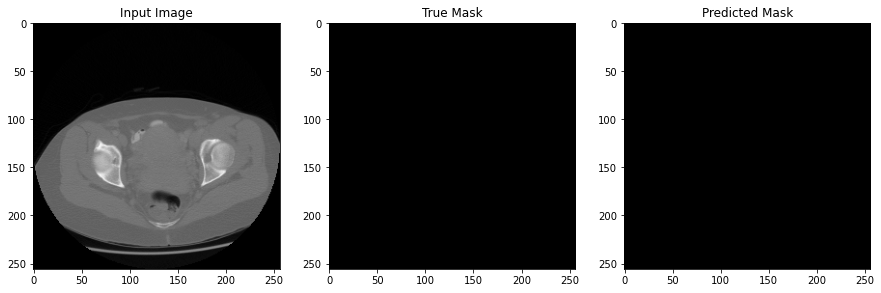

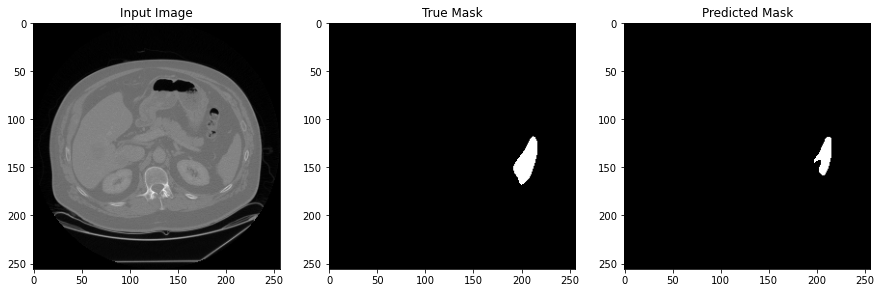

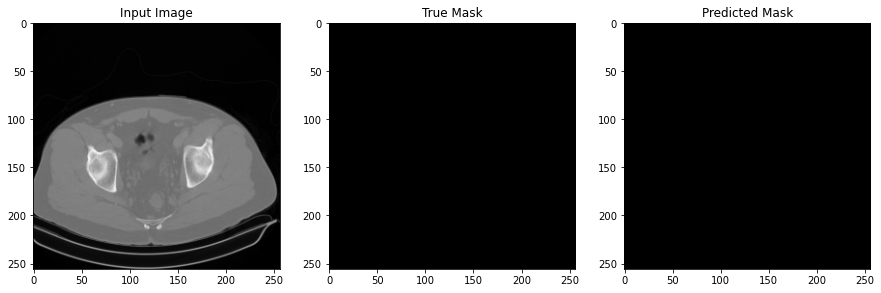

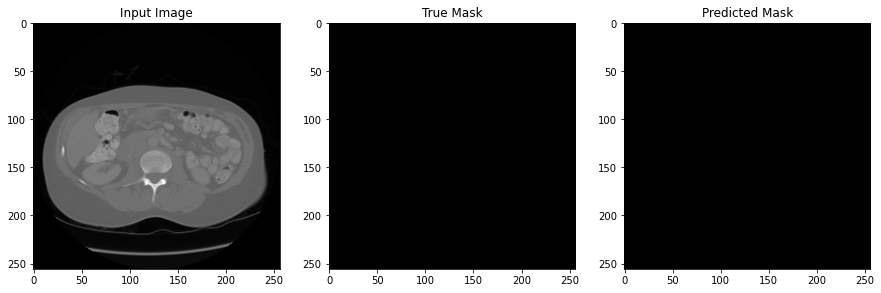

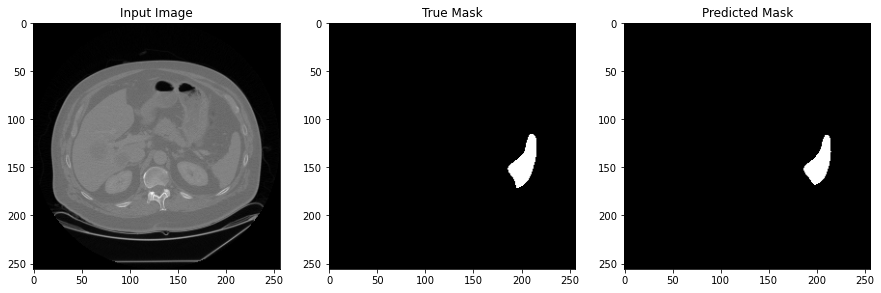

In [48]:
show_prediction(test_generator, 12)